In [80]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import glob
import pylab as pl
import numpy as np
import matplotlib.animation as animation
import types
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import matplotlib.patches as patches
% matplotlib inline

In [81]:
from ArcticTools import hovmoller as hov

In [82]:
nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/Y*2008*.nc'))#*_ptrc_T*.nc'))
print("found *.nc file: \n{}".format(nc_filename))
ptrc=nc.Dataset(nc_filename[0])

uvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridU_19692008.nc')

vvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridV_19692008.nc')

wvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridW_19692008.nc')

found *.nc file: 
['/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/Y19682008.nc']


In [170]:
nav_lon=ptrc.variables['nav_lon'][:,:]
nav_lat=ptrc.variables['nav_lat'][:,:]
dep = ptrc.variables['deptht'][:]


tmask=nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
#mbathy=tmask.variables['mbathy'][0,400:,:]
e1t=tmask.variables['e1t'][0,400:,:]
e3t=tmask.variables['e3t'][0,:,400:,:]
tmask=tmask.variables['tmask'][0,:,400:,:]


bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]



In [4]:
def vel(keyword,T,ENG):
    'design to obtain velocity field'
    if keyword =='U':
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*U*%s*.nc'%(ENG,T)))
        uvel=nc.Dataset(nc_filename[0])        
        data =uvel.variables['vozocrtx'][0,:,400:,:]
    else:
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*V*%s*.nc'%(ENG,T)))
        vvel=nc.Dataset(nc_filename[0])
        data =vvel.variables['vomecrty'][0,:,400:,:]
    data =np.ma.masked_where(tmask==0,data)
    return data

In [5]:
m = Basemap(projection='npstere',boundinglat=67,lon_0=0,resolution='l',round='TRUE')
x_lon,y_lat = m(lonNEMO,latNEMO)

In [40]:
def Fram(year,ENG='exh001'):
    fig = plt.figure(figsize=(10,3))
    temp= hov.load_ts('T',T=year,tmask= tmask, ENG='exh001', key = '_t_')
    sal= hov.load_ts('S',T=year,tmask= tmask, ENG='exh001', key = '_s_')
    plt.subplot(121)
    plt.pcolor(nav_lon[-265,310:335],dep[:],np.ma.masked_invalid(temp[:,-265,310:335]),\
               cmap='Spectral_r');
    plt.colorbar()
    plt.ylim([0,1500]);plt.gca().invert_yaxis();
    plt.xlabel('x (km)');plt.ylabel('depth (m)')
    
    plt.subplot(122)
    plt.pcolor(nav_lon[-265,310:335],dep[:],np.ma.masked_invalid(sal[:,-265,310:335]),\
               cmap='Spectral_r');
    plt.colorbar();plt.ylim([0,1500])
    plt.gca().invert_yaxis();
    plt.xlabel('x (km)');plt.ylabel('depth (m)')

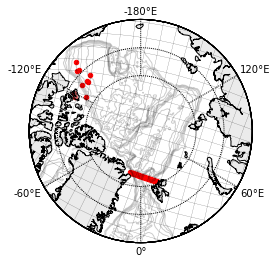

In [159]:
m,x_lon,y_lat = hov.mapping(70)
m.scatter(x_lon[-265,310:355],y_lat[-265,310:355],color='r')

xCB= np.random.randint(630-400,700-400,10)
yCB= np.random.randint(170,200,10)
m.scatter(x_lon[xCB,yCB],y_lat[xCB,yCB],color='r')

In [160]:
xCB,yCB

(array([281, 236, 232, 280, 295, 256, 264, 239, 276, 264]),
 array([178, 198, 178, 173, 171, 187, 196, 175, 197, 194]))

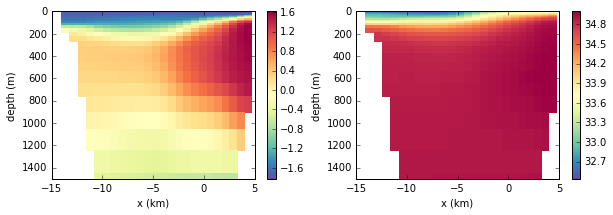

In [157]:
# t and s in the red line
Fram(2002)

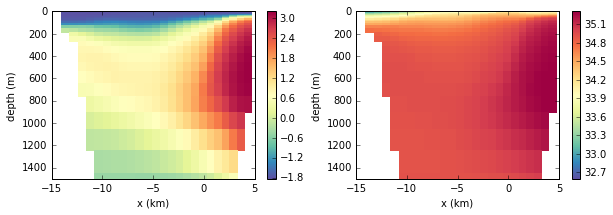

In [42]:
Fram(2010)

In [43]:
def load_v(vel_comp,T, tmask, ENG, key ):
    '''
    This function is designed to obtain velocity field
    ======================================================
    '''
    vels ={'U':'vozocrtx','V':'vomecrty','W':'vovecrtz'}

    with nc.Dataset(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*%s*%s.nc'%(ENG,vel_comp,T))[0])\
as temp:
        data  = temp.variables[vels[vel_comp]][0,:,400:,:]
    #data  = np.ma.masked_where(tmask == 0,data)
    return data

In [44]:
# grid for plotting
x1d=np.linspace(0,nav_lon[:,0].shape[0],nav_lat[:,0].shape[0])
y1d=np.linspace(0,nav_lon[0,:].shape[0],nav_lat[0,:].shape[0])
x2d,y2d=np.meshgrid(y1d,x1d)

In [65]:
def velField(year, layer,ENG='EXH001'):
    fig = plt.figure(figsize=(10,10))
    u= load_v('U',T=year,tmask= tmask, ENG='EXH001', key = 'U')
    v= load_v('V',T=year,tmask= tmask, ENG='EXH001', key = 'V')

    Q=plt.quiver(x2d[::4,::4], y2d[::4,::4], np.mean(u[:layer,::4,::4],axis=0), np.mean(v[:layer,::4,::4],axis=0),
               scale=2.,width=0.0025,color='k',alpha=0.7)
    Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})

    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
    plt.ylim(115,350)    
    plt.xlim(100,400)
    plt.title(year)
    return fig

In [62]:
# find a session on LR to identify the Transpolar Drift

dep[25]

186.12556

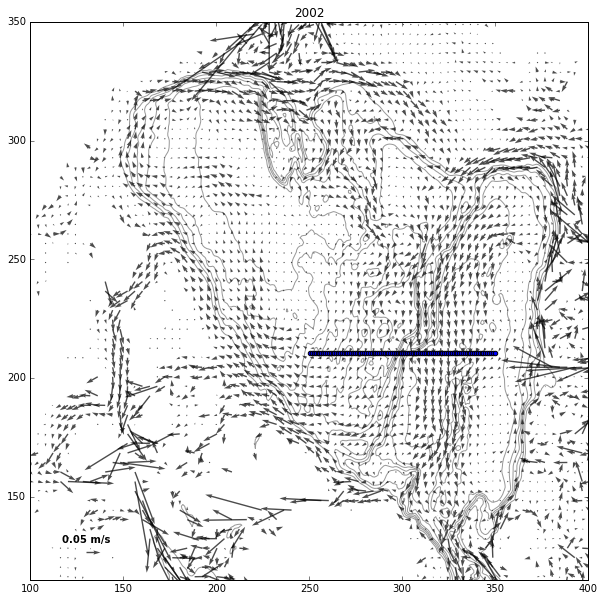

In [106]:
fig= velField(year=2002, layer=25,ENG='EXH001')
plt.scatter(x2d[210,250:350], y2d[210,250:350])

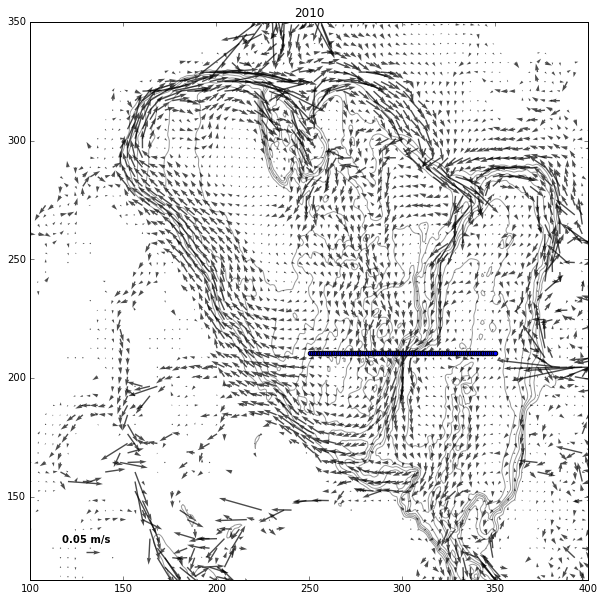

In [107]:
velField(year=2010, layer=25,ENG='EXH001')
plt.scatter(x2d[210,250:350], y2d[210,250:350])

In [171]:
def find_vel(yearnum,startyear,ENG):
    
    Fram_influx=[]
    Bsea_influx=[]
    year=[]
    a=[];b=[]
    
    vel_= {'u15':[],'u25':[],'u30':[],'u35':[], 'u39':[]}
    vkey={'u15':15,'u25':25, 'u30':30, 'u35':35 , 'u39':39}
    
    for time in range (yearnum):

        # loading vel
        u =vel('U',time+startyear,ENG)
        v =vel('V',time+startyear,ENG)
        aindex=325
        bindex=200
        for i,vlayer in zip (vel_.keys(),vkey.keys()):
            vel_[i].append(np.nanmean(v[vkey[vlayer],xCB,yCB]*np.cos(45)-u[vkey[vlayer],xCB,yCB]*np.sin(45))) 
        year.append(time+startyear)

    return np.array(year),vel_

In [172]:
# find vel
Year, vel_=\
find_vel(yearnum=12,startyear=2002,ENG='EXH001')

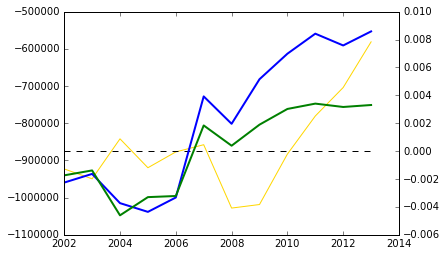

In [176]:
# find flux
Flux=[]
for year in range (2002,2014):
    v= load_v('V',T=year,tmask= tmask, ENG='EXH001', key = 'V')
    flux = 0
    for num in range(layer):
        flux += v[num,210,250:350] * e1t[210,250:350] *e3t[num,210,250:350]
    flux[flux >0] = np.nan
    Flux.append(flux)

# plot
fig, ax1 = plt.subplots()
ax1.plot(Year,np.nansum(np.array(Flux),axis=1),c='gold',label='EXH001')   

ax2 = ax1.twinx()        
ax2.plot(Year,np.ma.masked_invalid(vel_['u30'][:]),lw=2,label='depth: %s'%dep[30])
ax2.plot(Year,np.ma.masked_invalid(vel_['u35'][:]),lw=2,label='depth: %s'%dep[35])
ax2.hlines(y=0,xmin=np.min(Year),xmax=np.max(Year),linestyles='--')